In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib.pyplot import figure

In [2]:
# Read and format data
path = 'data/combined_data.csv' #change path

df_all = pd.read_csv(path)
df_all.date_time_current = pd.to_datetime(df_all.date_time_current, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_future = pd.to_datetime(df_all.date_time_future, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_current_rounded = pd.to_datetime(df_all.date_time_current_rounded, format = "%Y-%m-%d %H:%M:%S")

df_all["forecast_interval"] = df_all.date_time_future - df_all.date_time_current_rounded
df_all["forecast_error"] = df_all.total_demand - df_all.forecast_demand

In [3]:
#df_all["forecast_interval"] = df_all.period_id/2
#df_all.forecast_interval = df_all.forecast_interval.apply(lambda x: pd.Timedelta(hours=x))
df_all["forecast_error_relative"] = df_all.forecast_error/df_all.total_demand

df_all["date_time_future_month"] = df_all.date_time_future.dt.month
df_all["date_time_future_year"] = df_all.date_time_future.dt.year
df_all["date_time_future_weekday"] = df_all.date_time_future.dt.dayofweek
df_all["date_time_future_yearTime"] = df_all.date_time_future_year.apply(lambda x: pd.DateOffset(years=x-2000))
#df_all.date_time_future_yearTime = df_all.date_time_future - df_all.date_time_future_yearTime

Correlation = 0.1715401370942378


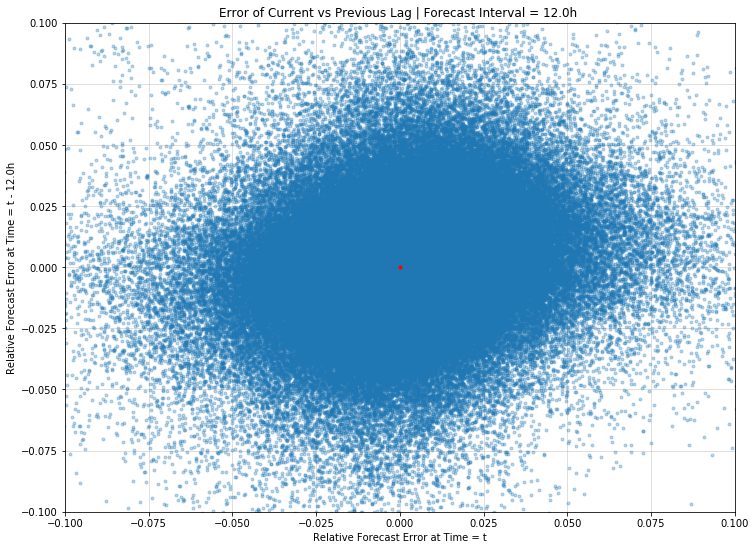

In [4]:
delta = 24

df_all_delta = df_all.loc[df_all.period_id == delta].sort_values("date_time_future").reset_index(drop = True)

x = df_all_delta.forecast_error_relative[delta:len(df_all_delta)]
y = df_all_delta.forecast_error_relative[0:len(df_all_delta)-delta]

plt.figure(figsize = (12, 9))
plt.plot(np.array(x), np.array(y), '.', alpha = 0.3)
plt.plot(0,0, 'r.')
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.grid(alpha = 0.5)
plt.xlabel('Relative Forecast Error at Time = t')
plt.ylabel('Relative Forecast Error at Time = t - {}h'.format(delta/2))
plt.title('Error of Current vs Previous Lag | Forecast Interval = {}h '.format(delta/2))
print("Correlation = {}".format(np.corrcoef(x, y)[0,1]))

Correlation = 0.3258149258247756


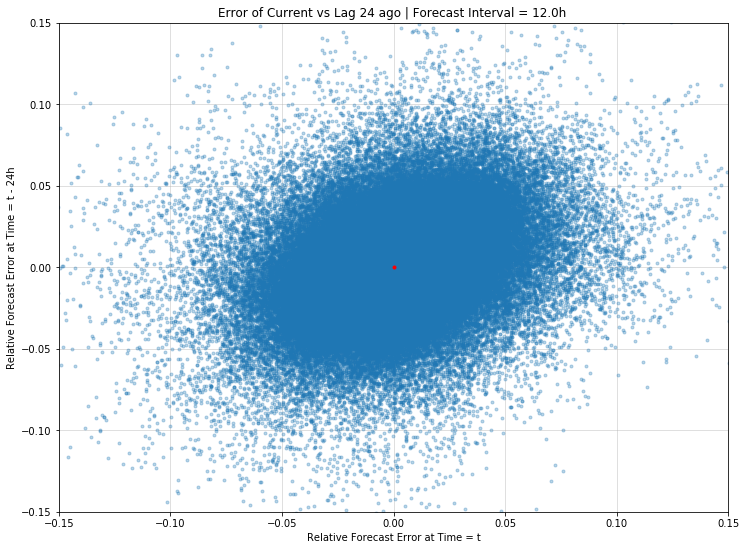

In [5]:
delta = 24
previous_lag = 48

df_all_delta = df_all.loc[df_all.period_id == delta].sort_values("date_time_future").reset_index(drop = True)
delta_24h_later = 48 - delta

x = df_all_delta.forecast_error_relative[previous_lag:len(df_all_delta)]
y = df_all_delta.forecast_error_relative[0:len(df_all_delta)-previous_lag]

plt.figure(figsize = (12, 9))
plt.plot(np.array(x), np.array(y), '.', alpha = 0.3)
plt.plot(0,0, 'r.')
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.grid(alpha = 0.5)
plt.xlabel('Relative Forecast Error at Time = t')
plt.ylabel('Relative Forecast Error at Time = t - 24h')
plt.title('Error of Current vs Lag 24 ago | Forecast Interval = {}h '.format(delta/2))
print("Correlation = {}".format(np.corrcoef(x, y)[0,1]))

In [6]:
periods = []
corr_timestep_1 = []
corr_timestep_2 = []
corr_timestep_3 = []

for period_id in set(df_all.period_id):
    periods = np.concatenate([periods, [period_id/2]])  
    
    df_all_delta = df_all.loc[df_all.period_id == period_id].sort_values("date_time_future").reset_index(drop = True)
        
    try:
        first_lag_time = df_all_delta.date_time_future.iloc[0] + pd.DateOffset(hours = period_id/2)
        first_lag_time_index = df_all_delta.loc[df_all_delta.date_time_future == first_lag_time].index[0]

        second_lag_time = df_all_delta.date_time_future.iloc[0] + pd.DateOffset(hours = 2*period_id/2)
        second_lag_time_index = df_all_delta.loc[df_all_delta.date_time_future == second_lag_time].index[0]
        
        third_lag_time = df_all_delta.date_time_future.iloc[0] + pd.DateOffset(hours = 3*period_id/2)
        third_lag_time_index = df_all_delta.loc[df_all_delta.date_time_future == third_lag_time].index[0]
        
    except: pass
    
    x1 = df_all_delta.forecast_error_relative[first_lag_time_index : len(df_all_delta)]
    y1 = df_all_delta.forecast_error_relative[0 : len(df_all_delta) - first_lag_time_index]
    
    x2 = df_all_delta.forecast_error_relative[second_lag_time_index : len(df_all_delta)]
    y2 = df_all_delta.forecast_error_relative[0 : len(df_all_delta) - second_lag_time_index]
    
    x3 = df_all_delta.forecast_error_relative[third_lag_time_index : len(df_all_delta)]
    y3 = df_all_delta.forecast_error_relative[0 : len(df_all_delta) - third_lag_time_index]
    
    corr_timestep_1 = np.concatenate([corr_timestep_1, [np.corrcoef(x1, y1)[0,1]]])
    corr_timestep_2 = np.concatenate([corr_timestep_2, [np.corrcoef(x2, y2)[0,1]]])
    corr_timestep_3 = np.concatenate([corr_timestep_3, [np.corrcoef(x3, y3)[0,1]]])

Text(0, 0.5, 'Correlation')

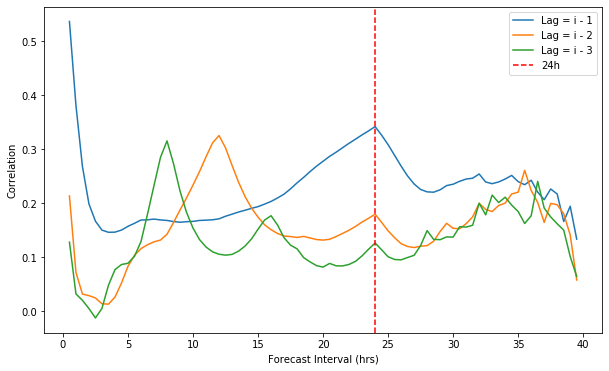

In [7]:
plt.figure(figsize = (10, 6))
plt.plot(periods, corr_timestep_1, label = 'Lag = i - 1')
plt.plot(periods, corr_timestep_2, label = 'Lag = i - 2')
plt.plot(periods, corr_timestep_3, label = 'Lag = i - 3')
plt.axvline(24, color = "r", ls = '--', label = '24h')
plt.legend()
plt.xlabel('Forecast Interval (hrs)')
plt.ylabel('Correlation')

In [8]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -31.926828
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


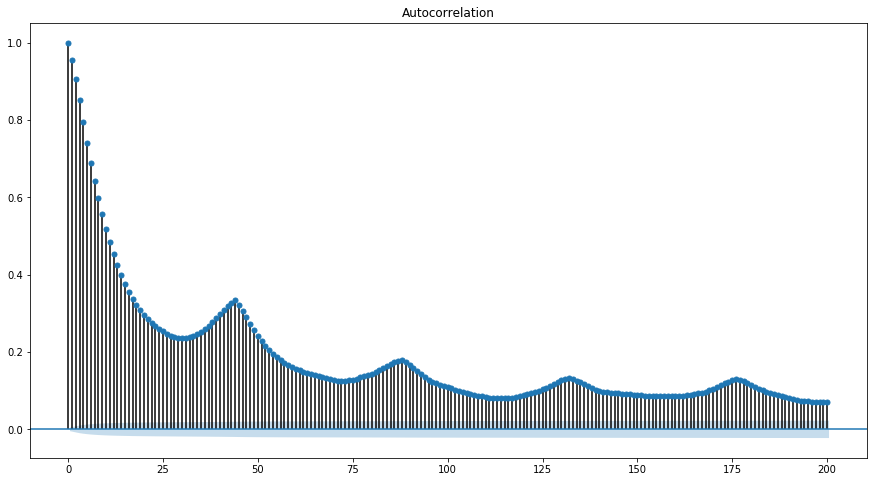

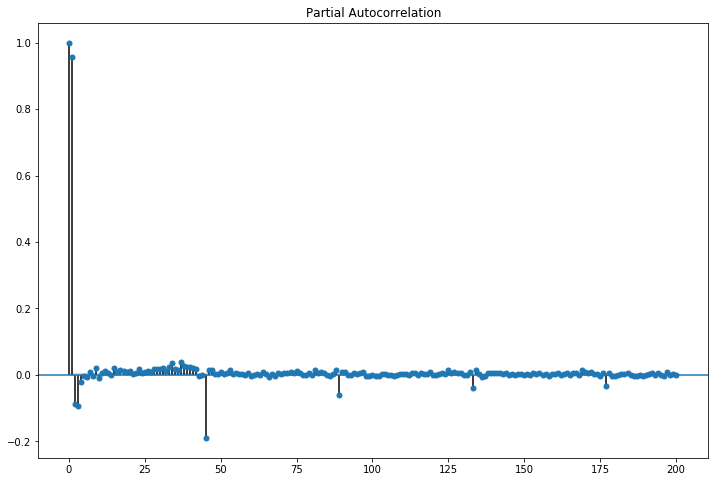

In [9]:
period_id = 36
year_portion = 0.1

fig, ax = plt.subplots(figsize = (15, 8))
df_all_delta = df_all.loc[df_all.period_id == period_id].sort_values("date_time_future").reset_index(drop = True)

check_stationarity(df_all_delta.forecast_error_relative)

plot_acf(df_all_delta.forecast_error_relative, lags = 200, ax = ax)
plt.show()
plt.rcParams["figure.figsize"] = (12, 8)

plot_pacf(df_all_delta.forecast_error_relative, lags = 200)
plt.show()
plt.rcParams["figure.figsize"] = (12, 8)

Check these:
- https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf
- https://medium.com/@kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5
    - https://stackoverflow.com/questions/68398481/how-to-skip-the-the-first-lag-n-days-in-arima-model-python
    - https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-3/


### Explanatory variables
Current variables to explain error:
- Error of previous forecast (with same forecast interval) 24 hours ago (this notebook). 48h ago may also help.
- Forecasted temperature at future time
- Day of the week (future date)
- Month (future date)

Example inputs for predicting total demand for "2010-02-02 12:00:00" (future) at "2010-02-02 00:00:00" (current):
- Error of the forecast for "2010-02-01 12:00:00" at "2010-02-01 00:00:00"
- Forecast temperature at "2010-02-01 12:00:00"
- Day of the week = "Monday"
- Month = "February"

## Linear Regression
Forecast interval = 12h

Check: https://realpython.com/linear-regression-in-python/

In [10]:
delta = 24

df_lag = df_all.loc[df_all.period_id == delta].sort_values("date_time_future").reset_index(drop = True)
df_lag_temp = df_lag.copy()[["forecast_error", "forecast_error_relative", "date_time_future"]].rename({"forecast_error" : "forecast_error_24h_ago", 
                                                                                                       "forecast_error_relative":  "forecast_error_relative_24h_ago",
                                                                                                       "date_time_future": "date_time_future_24h_ago"}, axis = 1)

df_lag["date_time_current_24h_ago"] = df_all_delta.date_time_current - pd.DateOffset(hours = 24)
df_lag["date_time_future_24h_ago"] = df_all_delta.date_time_future - pd.DateOffset(hours = 24)

df_lag = df_lag.loc[df_lag.date_time_future_24h_ago >= min(df_lag.date_time_future)]
df_lag = pd.merge(df_lag, df_lag_temp, on = "date_time_future_24h_ago", how = 'left')
df_lag = df_lag.loc[df_lag.forecast_error_relative_24h_ago.notna()]

mse = (1/len(df_lag))*sum(df_lag.forecast_error**2)
mae = (1/len(df_lag))*sum(abs(df_lag.forecast_error/df_lag.total_demand))
print(f"Existing model MSE = {round(mse)}")
print(f"Existing model MAPE = {round(100*mae,2)}%")

Existing model MSE = 54985
Existing model MAPE = 2.04%


In [11]:
df_lm = df_lag.copy()
df_lm["week_day_name"] = df_lm.date_time_future.dt.day_name()

df_lm["isSaturday"] = df_lm.week_day_name.apply(lambda x: 1 if x == 'Saturday' else 0)
df_lm["isSunday"] = df_lm.week_day_name.apply(lambda x: 1 if x == 'Sunday' else 0)

df_lm["isDecember"] = df_lm.date_time_future_month.apply(lambda x: 1 if x == 12 else 0)
df_lm["isJanuary"] = df_lm.date_time_future_month.apply(lambda x: 1 if x == 1 else 0)
df_lm["isFebruary"] = df_lm.date_time_future_month.apply(lambda x: 1 if x == 2 else 0)

In [12]:
x_columns = ["forecast_error_24h_ago"]
x = sm.add_constant(df_lm[x_columns])
x = sm.add_constant(x)
y = np.array(df_lm.forecast_error)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

df_lm["forecast_error_pred"] = results.predict(x)
df_lm["forecast_demand_new"] = df_lm.forecast_demand + df_lm.forecast_error_pred

df_lm["forecast_demand_new_error"] = df_lm.forecast_demand_new - df_lm.total_demand
mse_new = (1/len(df_lm))*sum((df_lm.forecast_demand_new_error)**2)
mape_new = (1/len(df_lag))*sum(abs(df_lm.forecast_demand_new_error/df_lm.total_demand))
print(f"\nNew model MSE = {round(mse_new)}")
print(f"New model MAPE = {round(100*mape_new,2)}%")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     126.1
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           2.96e-29
Time:                        17:56:07   Log-Likelihood:            -1.2275e+06
No. Observations:              178532   AIC:                         2.455e+06
Df Residuals:                  178530   BIC:                         2.455e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

In [13]:
x_columns = ["forecast_error_24h_ago", "isSaturday", "isSunday", "isDecember", "isJanuary", "isFebruary"]
x = sm.add_constant(df_lm[x_columns])
y = np.array(df_lm.forecast_error)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

df_lm["forecast_error_pred"] = results.predict(x)
df_lm["forecast_demand_new"] = df_lm.forecast_demand + df_lm.forecast_error_pred

df_lm["forecast_demand_new_error"] = df_lm.forecast_demand_new - df_lm.total_demand
mse_new = (1/len(df_lm))*sum((df_lm.forecast_demand_new_error)**2)
mape_new = (1/len(df_lag))*sum(abs(df_lm.forecast_demand_new_error/df_lm.total_demand))
print(f"\nNew model MSE = {round(mse_new)}")
print(f"New model MAPE = {round(100*mape_new,2)}%")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     359.8
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:56:07   Log-Likelihood:            -1.2265e+06
No. Observations:              178532   AIC:                         2.453e+06
Df Residuals:                  178525   BIC:                         2.453e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -10

Correlation = 0.31952959295859057


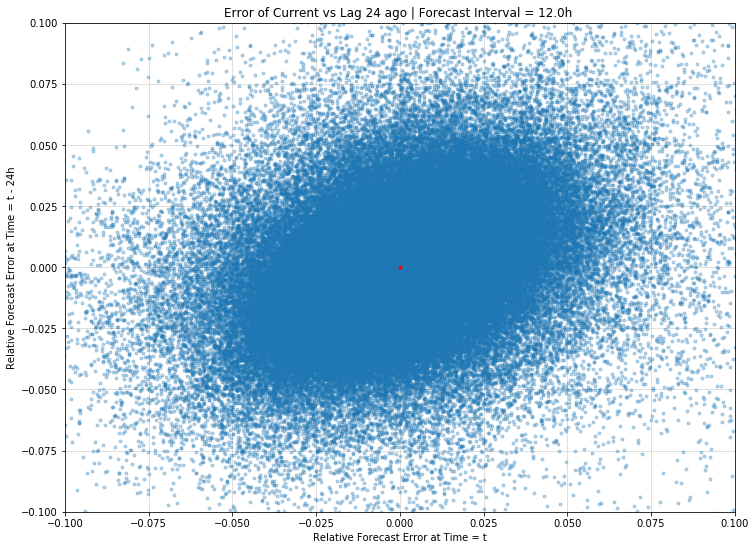

In [14]:
df_lm["forecast_demand_new_error_relative"] = df_lm.forecast_demand_new_error/df_lm.total_demand

x = df_lm.forecast_demand_new_error_relative[48:len(df_lm)]
y = df_lm.forecast_demand_new_error_relative[0:len(df_lm)-48]

plt.figure(figsize = (12, 9))
plt.plot(np.array(x), np.array(y), '.', alpha = 0.3)
plt.plot(0,0, 'r.')
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.grid(alpha = 0.5)
plt.xlabel('Relative Forecast Error at Time = t')
plt.ylabel('Relative Forecast Error at Time = t - 24h')
plt.title('Error of Current vs Lag 24 ago | Forecast Interval = {}h '.format(delta/2))
print("Correlation = {}".format(np.corrcoef(x, y)[0,1]))